# Exploration of protein and RNA library size and feature autocorrelations

Zoë Steier

* Dataset: SLN-all
* Compare RNA and protein library sizes
* Explore heterogeneity of library sizes within B cells
* Compare autocorrelations of features in different latent spaces

## Imports and settings

In [1]:
# Import required packages

import os
import seaborn as sns
import numpy as np
import torch

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, UnsupervisedTrainer

import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted
import matplotlib.colors
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import sem
from scipy.stats import ranksums

from plotnine import *
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

set_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

## Load data

In [4]:
post_adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/totalVI/sln_all_intersect_results_post_adata.h5ad")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## Compare RNA and protein library sizes

In [5]:
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in post_adata.obs["leiden_subclusters"]
]

In [6]:
# Calculate library size of 111 panel

post_adata.obs["n_protein_counts_111"] = post_adata.obsm["protein_expression"].sum(axis=1)


In [7]:
# Add log library size to adata
post_adata.obs["loglibrary_protein"] = np.log1p(post_adata.obsm["protein_expression"].sum(axis=1))
post_adata.obs["loglibrary_RNA"] = np.log1p(post_adata.X.sum(axis=1))

In [8]:
# Make a new adata for include_cells
# Subset to batch 0 (SLN111-D1)

adata = post_adata.copy()[include_cells]
adata = adata[np.array(adata.obs["batch_indices"] == "0")]
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


View of AnnData object with n_obs × n_vars = 8736 × 4005 
    obs: 'leiden_totalVI_1.0', 'leiden_totalVI_0.8', 'leiden_totalVI_0.6', 'leiden_totalVI_0.4', 'annotations', 'leiden_subclusters', 'batch_indices', 'n_genes', 'n_protein_counts', 'n_proteins', 'n_RNA_counts', 'percent_mito', 'seurat_hash_id', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0

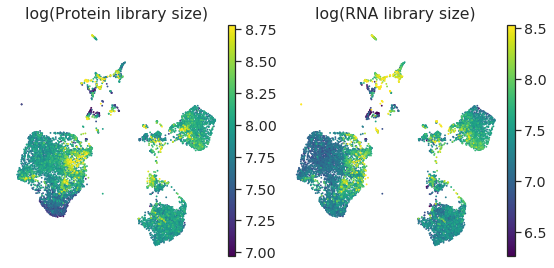

In [9]:
# Plot library sizes on UMAP

fig, ax_arr = plt.subplots(1,2, figsize = (4*2, 4))
title_arr = ["log(Protein library size)", "log(RNA library size)"]

for i, feature in enumerate(['loglibrary_protein', "loglibrary_RNA"]):
    sc.pl.umap(
        adata, 
        use_raw = False,
        color=feature, 
        ncols=1, 
        color_map = "viridis",
        frameon = False,
        ax = ax_arr.flat[i],
        vmax = "p99",
        vmin = "p1",
        show = False,
        title = title_arr[i]
    )
    
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/libsize_figures/libsize_UMAP.pdf", dpi = DPI)

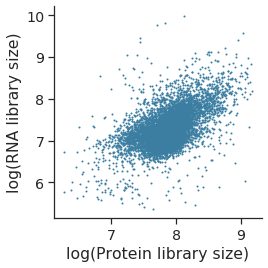

In [10]:
# Plot RNA vs protein library size

fig, ax = plt.subplots(figsize = (4,4))

ax.scatter(adata.obs["loglibrary_protein"], adata.obs["loglibrary_RNA"],
    s = 1, rasterized = True 
          )

ax.set(xlabel = "log(Protein library size)")
ax.set(ylabel = "log(RNA library size)")

sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/libsize_figures/libsize_RNA_protein_corr.pdf", dpi = DPI)

In [11]:
# How many cell types

len(adata.obs["annotations"].cat.categories)

27

In [12]:
RNA_protein_corr = np.corrcoef(x = adata.obs["loglibrary_protein"], 
                               y = adata.obs["loglibrary_RNA"],
                               rowvar = False)

RNA_protein_corr

array([[1.        , 0.54394541],
       [0.54394541, 1.        ]])

In [13]:
# Cells per cell type (exclude Plasma B from below analysis because there are too few cells to calculate a correlation)

pd.Series(adata.obs["annotations"]).value_counts()

Mature B cells               2733
CD4 T cells                  1519
Transitional B cells          867
CD8 T cells                   778
CD122+ CD8 T cells            560
Ifit3-high B cells            428
MZ B cells                    245
Ifit3-high CD4 T cells        188
B1 B cells                    184
NKT cells                     159
Tregs                         151
ICOS-high Tregs               127
Ifit3-high CD8 T cells         94
cDC1s                          87
NK cells                       82
Ly6-high monocytes             66
cDC2s                          63
GD T cells                     60
MZ/Marco-high macrophages      59
Activated CD4 T cells          58
Neutrophils                    53
pDCs                           41
Red-pulp macrophages           36
Ly6-low monocytes              33
Erythrocytes                   32
Migratory DCs                  31
Plasma B cells                  2
Name: annotations, dtype: int64

In [14]:
# Find correlation in each annotated cell type

cell_types = post_adata[include_cells].obs["annotations"].cat.categories
corrs = []
included_types = []

for cell_type in cell_types:
    if cell_type != "Plasma B cells":
        included_types = included_types + [cell_type]
        corr = np.corrcoef(x = (adata[np.array(adata.obs["annotations"] == cell_type)].obs["loglibrary_protein"]), 
                               y = (adata[np.array(adata.obs["annotations"] == cell_type)].obs["loglibrary_RNA"]),
                               rowvar = False)[0][1]
        corrs = corrs + [corr]

In [15]:
pd.DataFrame({"cell_type": included_types, "library_corr": corrs})

,cell_type,library_corr
0,Activated CD4 T cells,0.545648
1,B1 B cells,0.724774
2,CD4 T cells,0.561331
3,CD8 T cells,0.555340
4,CD122+ CD8 T cells,0.542673
5,Erythrocytes,0.466010
6,GD T cells,0.550435
7,ICOS-high Tregs,0.439914
8,Ifit3-high B cells,0.485765
9,Ifit3-high CD4 T cells,0.662270


In [16]:
np.min(corrs)

0.19820123324756705

In [17]:
np.max(corrs)

0.7762014803179059

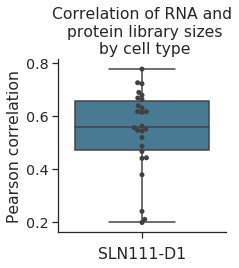

In [18]:
# Same as above, but swarmplot
fig, ax = plt.subplots(figsize = (3.5, 4))

ax = sns.boxplot(corrs, orient = "v")
ax = sns.swarmplot(corrs, orient = "v", color = "0.25") # data=tips, color=".25"


ax.set(xlabel = "SLN111-D1")
ax.set(ylabel = "Pearson correlation")
ax.set(title = "Correlation of RNA and\n protein library sizes\n by cell type") # "RNA-protein library size\n correlation by cell type") #

sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/libsize_figures/libsize_celltype_boxplot.pdf", dpi = DPI)

## Explore heterogeneity of library sizes within B cells 

In [45]:
adata.obs["annotations"].cat.categories

Index(['Activated CD4 T cells', 'B1 B cells', 'CD4 T cells', 'CD8 T cells',
       'CD122+ CD8 T cells', 'Erythrocytes', 'GD T cells', 'ICOS-high Tregs',
       'Ifit3-high B cells', 'Ifit3-high CD4 T cells',
       'Ifit3-high CD8 T cells', 'Ly6-high monocytes', 'Ly6-low monocytes',
       'MZ B cells', 'MZ/Marco-high macrophages', 'Mature B cells',
       'Migratory DCs', 'NK cells', 'NKT cells', 'Neutrophils',
       'Plasma B cells', 'Red-pulp macrophages', 'Transitional B cells',
       'Tregs', 'cDC1s', 'cDC2s', 'pDCs'],
      dtype='object')

In [46]:
# Calculate library size just based on RNA that encodes the mature B markers
# DE test is below
matureB_demarkers = np.array(['ADT_CD62L_A0112', 'ADT_Ly-6A-E(Sca-1)_A0130',
       'ADT_integrinb7_A0214', 'ADT_CD150(SLAM)_A0203',
       'ADT_CD21-CD35(CR2-CR1)_A0107', 'ADT_IgD_A0571', 'ADT_CD23_A0108',
       'ADT_CD274(B7-H1_PD-L1)_A0190', 'ADT_I-A-I-E_A0117',
       'ADT_CD200(OX2)_A0079'])
              
matureB_demarkers

array(['ADT_CD62L_A0112', 'ADT_Ly-6A-E(Sca-1)_A0130',
       'ADT_integrinb7_A0214', 'ADT_CD150(SLAM)_A0203',
       'ADT_CD21-CD35(CR2-CR1)_A0107', 'ADT_IgD_A0571', 'ADT_CD23_A0108',
       'ADT_CD274(B7-H1_PD-L1)_A0190', 'ADT_I-A-I-E_A0117',
       'ADT_CD200(OX2)_A0079'], dtype='<U28')

In [47]:
# Find matched RNA-protein names
encoded_proteins = pd.Series(adata.var["encode"][adata.var["encode"] != "None"], name = "Protein")

In [48]:
matureB_genes = [encoded_proteins.index[np.where(encoded_proteins == protein)[0][0]] for protein in matureB_demarkers]
matureB_genes

['Sell',
 'Ly6a',
 'Itgb7',
 'Slamf1',
 'Cr2',
 'Ighd',
 'Fcer2a',
 'Cd274',
 'H2-Aa',
 'Cd200']

In [57]:
# RNA expression
rna_mat = np.array(adata.X)
rna_df = pd.DataFrame(rna_mat, columns = adata.uns["totalVI_genes"])

# protein expression
prot_mat = np.array(adata.obsm["protein_expression"])
prot_df = pd.DataFrame(prot_mat, columns = adata.uns["totalVI_proteins"])

In [50]:
# log RNA library size (Restrict to encoding genes)
matureBgenes_lib_size = np.log1p(rna_df.loc[:, matureB_genes].sum(axis = 1)) # sum of top 10 mature markers in each cell)

# mature B
# transitional B
trans_matureBgenes = matureBgenes_lib_size[np.array(adata.obs["annotations"] == "Transitional B cells")]
mature_matureBgenes = matureBgenes_lib_size[np.array(adata.obs["annotations"] == "Mature B cells")]

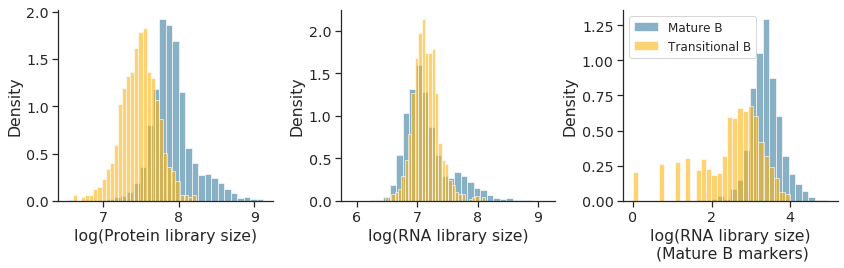

In [52]:
# Plot transitional and mature B cell library sizes in protein and RNA

fig, ax = plt.subplots(1,3, figsize = (12, 4)) # 10, 4
nbins = 30

ax[0].hist(adata[np.array(adata.obs["annotations"] == "Mature B cells")].obs["loglibrary_protein"],
          color = colors[0], alpha = 0.6, bins = nbins, density = True)
ax[0].hist(adata[np.array(adata.obs["annotations"] == "Transitional B cells") ].obs["loglibrary_protein"],
          color = colors[1], alpha = 0.6, bins = nbins, density = True)
ax[0].set(xlabel = "log(Protein library size)")
ax[0].set(ylabel = "Density")

ax[1].hist(adata[np.array(adata.obs["annotations"] == "Mature B cells") ].obs["loglibrary_RNA"],
          color = colors[0], alpha = 0.6, bins = nbins, density = True)
ax[1].hist(adata[np.array(adata.obs["annotations"] == "Transitional B cells") ].obs["loglibrary_RNA"],
          color = colors[1], alpha = 0.6, bins = nbins, density = True)
ax[1].set(xlabel = "log(RNA library size)")
ax[1].set(ylabel = "Density")

ax[2].hist(mature_matureBgenes,
          color = colors[0], alpha = 0.6, bins = nbins, density = True)
ax[2].hist(trans_matureBgenes,
          color = colors[1], alpha = 0.6, bins = nbins, density = True)
ax[2].set(xlabel = "log(RNA library size)\n (Mature B markers)")
ax[2].set(ylabel = "Density")
ax[2].legend(["Mature B", "Transitional B"], prop={'size': 12}, loc='upper left')


sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/libsize_figures/libsize_TransitionalMature.pdf", dpi = DPI)

In [53]:
# Welch's t-test
ttest_ind(adata[np.array(adata.obs["annotations"] == "Transitional B cells") ].obs["loglibrary_protein"],
         adata[np.array(adata.obs["annotations"] == "Mature B cells") ].obs["loglibrary_protein"],
         equal_var = False) 

Ttest_indResult(statistic=-43.49168622931379, pvalue=1.4023267489449763e-276)

In [54]:
ttest_ind(adata[np.array(adata.obs["annotations"] == "Transitional B cells") ].obs["loglibrary_RNA"],
         adata[np.array(adata.obs["annotations"] == "Mature B cells") ].obs["loglibrary_RNA"],
         equal_var = False)

Ttest_indResult(statistic=-1.6550645619243078, pvalue=0.09803138444760108)

In [55]:
ttest_ind(trans_matureBgenes, mature_matureBgenes,
         equal_var = False)

Ttest_indResult(statistic=-30.56578962340003, pvalue=4.338648274373363e-145)

## DE proteins contribution to library size

### Load data and model for DE

In [26]:
# Load anndata
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [27]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_111]

# Organize and instantiate scVI dataset
hvg_111 = anndataset.var["hvg_encode"]

dataset = AnnDatasetFromAnnData(ad=anndataset[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"]
)
dataset.initialize_cell_measurement(protein_data_111)
dataset.gene_names = anndataset[:, hvg_111].var_names.values

[2020-12-17 18:20:08,849] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 18:20:08,853] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 18:20:08,941] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 18:20:09,006] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [28]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 9264 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'protein_expression', 'local_vars', 'labels', 'batch_indices', 'local_means'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

In [29]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
)

In [30]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [31]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/differential_expression/saved_models/111_d1.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4115, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [32]:
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

In [33]:
# create posterior on full data

full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [34]:
# extract latent space

latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

In [35]:
# calculate protein background probabilities

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25

# Probability of background
py_mixing = np.mean(sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=False)
), axis=-1)
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)

In [36]:
# denoised data

denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True,
)

In [37]:
# Read the previously saved anndata object (only need to generate post_adata once)
adata_111d1 = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_111day1.h5ad")

### Run DE

In [38]:
# DE test between mature and transitional B cells
# Top DE proteins by LFC
# Fraction of library size made up of top biologically variable proteins

# Find cell types for DE

group1 = np.where(np.array(dataset.cell_types) == "Transitional B")[0]
group2 = np.where(np.array(dataset.cell_types) == "Mature B")[0]

labels = dataset.labels.ravel()

In [40]:
# Run one vs one DE test

transitional_vs_mature_de = full_posterior.differential_expression_score(
    idx1=labels==group1,
    idx2=labels==group2,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [41]:
# DE protein results: mature markers

mature_protein = transitional_vs_mature_de
mature_protein = mature_protein.iloc[mature_protein.index.str.contains("ADT_")]                                   

mature_protein = mature_protein.loc[mature_protein['bayes_factor'] > .7] 
mature_protein = mature_protein.sort_values(by = "median", ascending = True) 
mature_protein = mature_protein.loc[mature_protein["median"] < 0]

mature_protein

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_min,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
ADT_CD62L_A0112,0.9172,0.0828,2.404897,15.927847,77.910622,-4.368687,-6.887024,3.741391,-8.627234,7.535151,...,-8.403173,0.280146,-8.594027,6.543036,18.770473,81.620201,0.983852,0.999268,NaN,NaN
ADT_Ly-6A-E(Sca-1)_A0130,0.6760,0.3240,0.735450,8.381959,35.952610,-3.359572,-6.143054,4.016749,-9.210114,7.968407,...,-7.669607,6.739248,-8.567101,7.232789,16.560555,41.975483,0.998847,1.000000,NaN,NaN
ADT_integrinb7_A0214,0.8824,0.1176,2.015356,8.058406,27.228603,-3.395973,-5.443006,3.012272,-7.180512,6.203607,...,-6.761719,0.371821,-6.892993,5.516222,14.167243,27.289061,0.998847,0.999634,NaN,NaN
ADT_CD150(SLAM)_A0203,0.9162,0.0838,2.391802,8.752646,28.473663,-3.380534,-5.361651,2.824345,-7.146576,6.223266,...,-6.594371,0.256555,-6.943357,5.088394,10.769320,29.390413,0.989619,0.999634,NaN,NaN
ADT_CD21-CD35(CR2-CR1)_A0107,0.9580,0.0420,3.127178,14.339369,55.623852,-3.055823,-2.166599,2.631561,-8.896247,7.012292,...,-7.596962,0.351828,-8.619415,1.286246,13.889274,59.597511,0.980392,1.000000,NaN,NaN
ADT_IgD_A0571,0.9620,0.0380,3.231428,115.206039,411.139160,-3.044752,-2.045525,3.243956,-10.926152,9.478664,...,-10.184634,0.290276,-10.845722,1.570955,115.650520,432.256866,1.000000,1.000000,NaN,NaN
ADT_CD23_A0108,0.9344,0.0656,2.656329,18.274105,61.818306,-3.662293,-2.016987,3.243678,-8.129188,7.177583,...,-7.653973,0.208226,-7.997803,5.762841,19.169550,64.306259,0.978085,0.999634,NaN,NaN
ADT_CD274(B7-H1_PD-L1)_A0190,0.8020,0.1980,1.398842,5.906882,13.860413,-2.393666,-1.380805,2.475505,-6.857774,5.156113,...,-5.512184,0.459519,-5.906026,4.793375,8.987312,14.047201,0.997693,1.000000,NaN,NaN
ADT_I-A-I-E_A0117,0.9132,0.0868,2.353348,153.790375,350.641235,-2.111411,-1.227985,2.997911,-10.666430,9.503570,...,-9.815630,0.596297,-10.374124,1.132214,148.702423,365.467621,1.000000,1.000000,NaN,NaN
ADT_CD200(OX2)_A0079,0.9308,0.0692,2.599043,12.450583,25.175098,-1.153455,-0.965580,1.251192,-7.269903,5.502914,...,-5.518112,0.250926,-6.096833,0.948036,11.611303,25.450787,0.998847,1.000000,NaN,NaN


In [43]:
mature_protein_markers = mature_protein.index[0:10].values
mature_protein_markers

array(['ADT_CD62L_A0112', 'ADT_Ly-6A-E(Sca-1)_A0130',
       'ADT_integrinb7_A0214', 'ADT_CD150(SLAM)_A0203',
       'ADT_CD21-CD35(CR2-CR1)_A0107', 'ADT_IgD_A0571', 'ADT_CD23_A0108',
       'ADT_CD274(B7-H1_PD-L1)_A0190', 'ADT_I-A-I-E_A0117',
       'ADT_CD200(OX2)_A0079'], dtype=object)

In [58]:
# What fraction of library size difference do these proteins make up?

mini_lib_size = prot_df.loc[:, mature_protein_markers].sum(axis = 1) # sum of top 10 mature markers in each cell
total_lib_size = prot_df.sum(axis = 1) # total library size for 111 panel
mean_trans_total = np.mean(total_lib_size[np.array(adata.obs["annotations"] == "Transitional B cells")])
mean_mature_total = np.mean(total_lib_size[np.array(adata.obs["annotations"] == "Mature B cells")])
difference_total = mean_mature_total - mean_trans_total # on average, transitional are 1800, mature are 2800

mean_trans_mini = np.mean(mini_lib_size[np.array(adata.obs["annotations"] == "Transitional B cells")])
mean_mature_mini = np.mean(mini_lib_size[np.array(adata.obs["annotations"] == "Mature B cells")])
difference_mini = mean_mature_mini - mean_trans_mini # 400, 1100, difference is 700

frac_mature_markers_difference = difference_mini/difference_total
frac_mature_markers_difference 

# Interpretation: 74% of the difference in library size between mature and transitional is driven by the 10 most DE proteins
# These differences are biologically driven (IgD, CD23, Cd21)

0.73904806

In [59]:
# What fraction of expression do these markers make up in each cell type?

frac_mature_markers = mini_lib_size/total_lib_size
mean_frac_transitional = np.mean(frac_mature_markers[np.array(adata.obs["annotations"] == "Transitional B cells")])
mean_frac_mature = np.mean(frac_mature_markers[np.array(adata.obs["annotations"] == "Mature B cells")])

print("transitional fraction: " + str(mean_frac_transitional))
print("mature fraction: " + str(mean_frac_mature))

transitional fraction: 0.19075684
mature fraction: 0.39398214


In [60]:
# Calculate errors to plot

sem_trans_remaining = sem(total_lib_size[np.array(adata.obs["annotations"] == "Transitional B cells")] - 
                                           mini_lib_size[np.array(adata.obs["annotations"] == "Transitional B cells")])
sem_trans_mini = sem(mini_lib_size[np.array(adata.obs["annotations"] == "Transitional B cells")])
sem_mature_remaining = sem(total_lib_size[np.array(adata.obs["annotations"] == "Mature B cells")] - 
                             mini_lib_size[np.array(adata.obs["annotations"] == "Mature B cells")])
sem_mature_mini = sem(mini_lib_size[np.array(adata.obs["annotations"] == "Mature B cells")])

In [61]:
# Plot differences in library size as stacked bar chart
# Transitional, mature
N = 2
matureBmarkers = (mean_trans_mini, mean_mature_mini)
remainingproteins = (mean_trans_total - mean_trans_mini, mean_mature_total - mean_mature_mini)
matureBerrors = (sem_trans_mini, sem_mature_mini)
remainingerrors = (sem_trans_remaining, sem_mature_remaining)
ind = np.arange(N)
width = 0.5

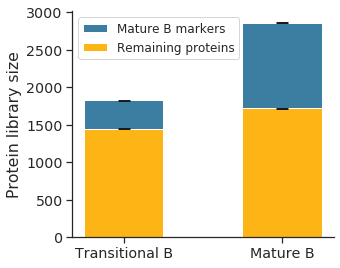

In [62]:
# Plot
fig, ax = plt.subplots(figsize=(5, 4)) 

p1 = ax.bar(ind, remainingproteins, width,
             yerr = remainingerrors, capsize = 6, color = colors[1])
p2 = ax.bar(ind, matureBmarkers, width, bottom = remainingproteins,
             yerr = matureBerrors, capsize = 6, color = colors[0])

ax.set(ylabel = 'Protein library size')
plt.xticks(ind, ('Transitional B', 'Mature B'))
ax.legend((p2[0], p1[0]), ('Mature B markers', 'Remaining proteins'), loc = "upper left", prop={'size': 12})

sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/libsize_figures/libsize_MatureB_DEmarkers.pdf", dpi = DPI)

## Estimated protein background

In [20]:
# Estimate number of protein UMI counts due to background using foreground probability < 0.5

# foreground probability for each protein
fore_cols = [col for col in post_adata.obs.columns if "fore_prob" in col]
fore_prob = pd.DataFrame(post_adata.obs).loc[:, fore_cols]

# raw protein counts
prot_raw = post_adata.obsm["protein_expression"]

# mask on foreground prob < 0.5
background_counts = prot_raw * (fore_prob < 0.5)


In [21]:
prot_raw.shape

(32648, 110)

In [22]:
# sum of background counts per batch
bg_per_batch = []
for batch in post_adata.obs["batch_indices"].cat.categories:
    bg = np.sum(background_counts.loc[post_adata.obs["batch_indices"] == batch, :], axis = 1) # bg in each cell
    total = np.sum(prot_raw[post_adata.obs["batch_indices"] == batch, :], axis = 1) # total in each cell
    bg_pct = np.median(bg/total) # median of bg/total in each cell
    bg_per_batch.append(bg_pct)
    
# fraction of background counts per batch
bg_per_batch

[0.117460474, 0.09892567, 0.13172385, 0.18047337]

In [23]:
# Median across all cells
bg = np.sum(background_counts, axis = 1) # bg in each cell
total = np.sum(prot_raw, axis = 1) # total in each cell
bg_pct = np.median(bg/total)
bg_pct

0.12712792

## Autocorrelation of library size in latent space

### Calculate Geary's C in totalVI latent space

In [684]:
# Save adata object
post_adata.write("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/post_adata_totalvi.h5ad", compression="gzip")

In [63]:
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=30, metric="correlation")
 # https://github.com/adamgayoso/totalVI_journal/blob/master/spleen_lymph_all/run_sln_all.py

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.p

In [64]:
# Geary's C from scanpy
# https://github.com/ivirshup/scanpy/blob/metrics/scanpy/metrics/_gearys_c.py

from typing import Optional, Union

from anndata import AnnData
from multipledispatch import dispatch
import numba
# import numpy as np
# import pandas as pd
from scipy import sparse


def _choose_obs_rep(adata, *, use_raw=False, layer=None, obsm=None, obsp=None):
    """
    Choose array aligned with obs annotation.
    """
    is_layer = layer is not None
    is_raw = use_raw is not False
    is_obsm = obsm is not None
    is_obsp = obsp is not None
    choices_made = sum((is_layer, is_raw, is_obsm, is_obsp))
    assert choices_made <= 1
    if choices_made == 0:
        return adata.X
    elif is_layer:
        return adata.layers[layer]
    elif use_raw:
        return adata.raw.X
    elif is_obsm:
        return adata.obsm[obsm]
    elif is_obsp:
        return adata.obsp[obsp]
    else:
        assert False, (
            "That was unexpected. Please report this bug at:\n\n\t"
            " https://github.com/theislab/scanpy/issues"
        )



###############################################################################
# Calculation
###############################################################################
# Some notes on the implementation:
# * This could be phrased as tensor multiplication. However that does not get
#   parallelized, which boosts performance almost linearly with cores.
# * Due to the umap setting the default threading backend, a parallel numba
#   function that calls another parallel numba function can get stuck. This
#   ends up meaning code re-use will be limited until umap 0.4.
#   See: https://github.com/lmcinnes/umap/issues/306
# * There can be a fair amount of numerical instability here (big reductions),
#   so data is cast to float64. Removing these casts/ conversion will cause the
#   tests to fail.


@numba.njit(cache=True, parallel=False)
def _gearys_c_vec(data, indices, indptr, x):
    W = data.sum()
    return _gearys_c_vec_W(data, indices, indptr, x, W)


@numba.njit(cache=True, parallel=False)
def _gearys_c_vec_W(data, indices, indptr, x, W):
    N = len(indptr) - 1
    x_bar = x.mean()
    x = x.astype(np.float_)

    total = 0.0
    for i in numba.prange(N):
        s = slice(indptr[i], indptr[i + 1])
        i_indices = indices[s]
        i_data = data[s]
        total += np.sum(i_data * ((x[i] - x[i_indices]) ** 2))

    numer = (N - 1) * total
    denom = 2 * W * ((x - x_bar) ** 2).sum()
    C = numer / denom

    return C


@numba.njit(cache=True, parallel=False)
def _gearys_c_mtx_csr(
    g_data, g_indices, g_indptr, x_data, x_indices, x_indptr, x_shape
):
    M, N = x_shape
    W = g_data.sum()
    out = np.zeros(M, dtype=np.float_)
    for k in numba.prange(M):
        x_k = np.zeros(N, dtype=np.float_)
        sk = slice(x_indptr[k], x_indptr[k + 1])
        x_k_data = x_data[sk]
        x_k[x_indices[sk]] = x_k_data
        x_k_bar = np.sum(x_k_data) / N
        total = 0.0
        for i in numba.prange(N):
            s = slice(g_indptr[i], g_indptr[i + 1])
            i_indices = g_indices[s]
            i_data = g_data[s]
            total += np.sum(i_data * ((x_k[i] - x_k[i_indices]) ** 2))
        numer = (N - 1) * total
        # Expanded from 2 * W * ((x_k - x_k_bar) ** 2).sum(), but uses sparsity
        # to skip some calculations
        # fmt: off
        denom = (
            2 * W
            * (
                np.sum(x_k_data ** 2)
                - np.sum(x_k_data * x_k_bar * 2)
                + (x_k_bar ** 2) * N
            )
        )
        C = numer / denom
        out[k] = C
    return out


# Simplified implementation, hits race condition after umap import due to numba
# parallel backend
# @numba.njit(cache=True, parallel=False)
# def _gearys_c_mtx_csr(
#     g_data, g_indices, g_indptr, x_data, x_indices, x_indptr, x_shape
# ):
#     M, N = x_shape
#     W = g_data.sum()
#     out = np.zeros(M, dtype=np.float64)
#     for k in numba.prange(M):
#         x_arr = np.zeros(N, dtype=x_data.dtype)
#         sk = slice(x_indptr[k], x_indptr[k + 1])
#         x_arr[x_indices[sk]] = x_data[sk]
#         outval = _gearys_c_vec_W(g_data, g_indices, g_indptr, x_arr, W)
#         out[k] = outval
#     return out


@numba.njit(cache=True, parallel=False)
def _gearys_c_mtx(g_data, g_indices, g_indptr, X):
    M, N = X.shape
    W = g_data.sum()
    out = np.zeros(M, dtype=np.float_)
    for k in numba.prange(M):
        x = X[k, :].astype(np.float_)
        x_bar = x.mean()

        total = 0.0
        for i in numba.prange(N):
            s = slice(g_indptr[i], g_indptr[i + 1])
            i_indices = g_indices[s]
            i_data = g_data[s]
            total += np.sum(i_data * ((x[i] - x[i_indices]) ** 2))

        numer = (N - 1) * total
        denom = 2 * W * ((x - x_bar) ** 2).sum()
        C = numer / denom

        out[k] = C
    return out


# Similar to above, simplified version umaps choice of parallel backend breaks:
# @numba.njit(cache=True, parallel=False)
# def _gearys_c_mtx(g_data, g_indices, g_indptr, X):
#     M, N = X.shape
#     W = g_data.sum()
#     out = np.zeros(M, dtype=np.float64)
#     for k in numba.prange(M):
#         outval = _gearys_c_vec_W(g_data, g_indices, g_indptr, X[k, :], W)
#         out[k] = outval
#     return out


###############################################################################
# Interface
###############################################################################


@dispatch(sparse.csr_matrix, sparse.csr_matrix)
def gearys_c(g, vals) -> np.ndarray:
    assert g.shape[0] == g.shape[1], "`g` should be a square adjacency matrix"
    assert g.shape[0] == vals.shape[1]
    return _gearys_c_mtx_csr(
        g.data.astype(np.float_, copy=False),
        g.indices,
        g.indptr,
        vals.data.astype(np.float_, copy=False),
        vals.indices,
        vals.indptr,
        vals.shape,
    )


@dispatch(sparse.spmatrix, np.ndarray)  # noqa
def gearys_c(g, vals):
    """\
    Params
    ------
    g
        Connectivity graph as a scipy sparse matrix. Should have shape:
        `(n_obs, n_obs)`.
    vals
        Values to calculate Geary's C for. If one dimensional, should have
        shape `(n_obs,)`. If two dimensional (i.e calculating Geary's C for
        multiple variables) should have shape `(n_vars, n_obs)`.
    """
    assert g.shape[0] == g.shape[1], "`g` should be a square matrix."
    if not isinstance(g, sparse.csr_matrix):
        g = g.tocsr()
    g_data = g.data.astype(np.float_, copy=False)
    if vals.ndim == 1:
        assert g.shape[0] == vals.shape[0]
        return _gearys_c_vec(g_data, g.indices, g.indptr, vals)
    elif vals.ndim == 2:
        assert g.shape[0] == vals.shape[1]
        return _gearys_c_mtx(g_data, g.indices, g.indptr, vals)
    else:
        raise ValueError()


@dispatch(sparse.spmatrix, (pd.DataFrame, pd.Series))  # noqa
def gearys_c(g, vals):
    return gearys_c(g, vals.values)


@dispatch(sparse.spmatrix, sparse.spmatrix)  # noqa
def gearys_c(g, vals) -> np.ndarray:
    if not isinstance(g, sparse.csr_matrix):
        g = g.tocsr()
    if not isinstance(vals, sparse.csr_matrix):
        vals = vals.tocsr()
    return gearys_c(g, vals)


# TODO: Document better
# TODO: Have scanpydoc work with multipledispatch
@dispatch(AnnData)  # noqa
def gearys_c(
    adata: AnnData,
    *,
    vals: Optional[Union[np.ndarray, sparse.spmatrix]] = None,
    use_graph: Optional[str] = None,
    layer: Optional[str] = None,
    obsm: Optional[str] = None,
    obsp: Optional[str] = None,
    use_raw: bool = False,
) -> Union[np.ndarray, float]:
    """\
    Calculate `Geary's C` <https://en.wikipedia.org/wiki/Geary's_C>`_, as used
    by `VISION <https://doi.org/10.1038/s41467-019-12235-0>`_.
    Geary's C is a measure of autocorrelation for some measure on a graph. This
    can be to whether measures are correlated between neighboring cells. Lower
    values indicate greater correlation.
    ..math
        C =
        \frac{
            (N - 1)\sum_{i,j} w_{i,j} (x_i - x_j)^2
        }{
            2W \sum_i (x_i - \bar{x})^2
        }
    Params
    ------
    adata
    vals
        Values to calculate Geary's C for. If this is two dimensional, should
        be of shape `(n_features, n_cells)`. Otherwise should be of shape
        `(n_cells,)`. This matrix can be selected from elements of the anndata
        object by using key word arguments: `layer`, `obsm`, `obsp`, or
        `use_raw`.
    use_graph
        Key to use for graph in anndata object. If not provided, default
        neighbors connectivities will be used instead.
    layer
        Key for `adata.layers` to choose `vals`.
    obsm
        Key for `adata.obsm` to choose `vals`.
    obsp
        Key for `adata.obsp` to choose `vals`.
    use_raw
        Whether to use `adata.raw.X` for `vals`.
    Returns
    -------
    If vals is two dimensional, returns a 1 dimensional ndarray array. Returns
    a scalar if `vals` is 1d.
    """
    if use_graph is None:
        # Fix for anndata<0.7
        if hasattr(adata, "obsp") and "connectivities" in adata.obsp:
            g = adata.obsp["connectivities"]
        elif "neighbors" in adata.uns:
            g = adata.uns["neighbors"]["connectivities"]
        else:
            raise ValueError("Must run neighbors first.")
    else:
        raise NotImplementedError()
    if vals is None:
        vals = _choose_obs_rep(
            adata, use_raw=use_raw, layer=layer, obsm=obsm, obsp=obsp
        ).T
    return gearys_c(g, vals)

In [65]:
post_adata.uns["neighbors"]["connectivities"].shape

(32648, 32648)

In [66]:
# All cells RNA
gearys_c(post_adata.uns["neighbors"]["connectivities"], post_adata.obs["loglibrary_RNA"])

0.4037337626293721

In [67]:
# All cells protein
gearys_c(post_adata.uns["neighbors"]["connectivities"], post_adata.obs["loglibrary_protein"])

0.4874718803090722

In [68]:
# All clusters RNA
rna_geary_clusters = []
protein_geary_clusters = []
for cluster in post_adata[include_cells].obs["annotations"].cat.categories:
    sub_adata = post_adata[np.array(post_adata.obs["annotations"] == cluster)]
    geary_clust_r = gearys_c(sub_adata.uns["neighbors"]["connectivities"], sub_adata.obs["loglibrary_RNA"])
    geary_clust_p = gearys_c(sub_adata.uns["neighbors"]["connectivities"], sub_adata.obs["loglibrary_protein"])

    rna_geary_clusters.append(geary_clust_r)
    protein_geary_clusters.append(geary_clust_p)

In [69]:
gearyC_clusters = post_adata[include_cells].obs["annotations"].cat.categories

In [70]:
gearyC_results = pd.DataFrame({"cell_type": post_adata[include_cells].obs["annotations"].cat.categories,
             "RNA_gearyC": rna_geary_clusters,
             "protein_gearyC": protein_geary_clusters})

In [71]:
gearyC_results

,cell_type,RNA_gearyC,protein_gearyC
0,Activated CD4 T cells,0.739950,0.876123
1,B1 B cells,0.490334,0.632262
2,CD4 T cells,0.712949,0.742995
3,CD8 T cells,0.652837,0.725333
4,CD122+ CD8 T cells,0.721191,0.698965
5,Erythrocytes,0.357682,0.196072
6,GD T cells,0.623765,0.569478
7,ICOS-high Tregs,0.448157,0.622925
8,Ifit3-high B cells,0.633973,0.671083
9,Ifit3-high CD4 T cells,0.723087,0.830753


In [685]:
gearyC_results.to_csv("gearyC_totalVI.csv")

In [72]:
np.sum(gearyC_results["RNA_gearyC"] > gearyC_results["protein_gearyC"])

13

In [73]:
len(gearyC_results)

27

### Run scVI to calculate Geary's C in RNA-only latent space

In [74]:
# Load data 
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_111

[2020-12-17 18:54:19,437] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 18:54:19,441] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 18:54:19,580] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 18:54:19,697] INFO - scvi.dataset.dataset | Downsampled from 16828 to 16828 cells


GeneExpressionDataset object with n_cells x nb_genes = 16828 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_means', 'local_vars', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [75]:
dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values

dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206],)
dataset

[2020-12-17 18:54:26,077] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 18:54:26,079] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 18:54:26,189] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 18:54:26,298] INFO - scvi.dataset.dataset | Downsampled from 15820 to 15820 cells
[2020-12-17 18:54:26,599] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-12-17 18:54:26,859] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 18:54:27,050] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 18:54:27,051] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 18:54:27,294] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 18:54:27,474] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 18:54:27,475] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 18:54:

GeneExpressionDataset object with n_cells x nb_genes = 32648 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_means', 'local_vars', 'labels'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [24]:
dataset.n_batches

4

In [25]:
use_cuda = True

scvi_vae = VAE(dataset.nb_genes, reconstruction_loss="nb", n_latent=20, n_batch=dataset.n_batches)
scvi_trainer = UnsupervisedTrainer(
    scvi_vae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=10,
    data_loader_kwargs={"pin_memory": False} # no batch_size for scVI
)

In [26]:
# Run scvi

scvi_trainer.train(lr = 4e-3, n_epochs = 300)

[2020-09-10 16:29:20,862] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.



[2020-09-10 16:51:49,552] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [27]:
full_scvi_posterior = scvi_trainer.create_posterior(
    scvi_vae, dataset, indices=np.arange(len(dataset)),
)

In [28]:
# extract latent space
latent_mean, batch_index, label = full_scvi_posterior.sequential().get_latent()

In [30]:
latent_mean.shape

(32648, 20)

In [31]:
# Make post_adata

post_adata_new = anndata.AnnData(post_adata.X, obs = post_adata.obs, var = post_adata.var)
post_adata_new.obsm["X_scVI"] = latent_mean
post_adata_new

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 32648 × 4005 
    obs: 'leiden_totalVI_1.0', 'leiden_totalVI_0.8', 'leiden_totalVI_0.6', 'leiden_totalVI_0.4', 'annotations', 'leiden_subclusters', 'batch_indices', 'n_genes', 'n_protein_counts', 'n_proteins', 'n_RNA_counts', 'percent_mito', 'seurat_hash_id', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', '

In [129]:
# find neighbors
sc.pp.neighbors(post_adata_new, use_rep="X_scVI", n_neighbors=30, metric="correlation")

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [33]:
# Make unique names
post_adata_new.obs_names_make_unique()

In [35]:
len((np.unique(post_adata_new.obs.index)))

32648

In [34]:
# Save adata object
post_adata_new.write("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/post_adata_scvi.h5ad", compression="gzip")

In [76]:
post_adata_new = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/post_adata_scvi.h5ad")

In [77]:
# Calculate Geary's C

# All clusters RNA

rna_geary_clusters_scvi = []

for cluster in post_adata_new[include_cells].obs["annotations"].cat.categories:
    sub_adata = post_adata_new[np.array(post_adata_new.obs["annotations"] == cluster)].copy()
    geary_clust_r = gearys_c(sub_adata.uns["neighbors"]["connectivities"], sub_adata.obs["loglibrary_RNA"].values)
    rna_geary_clusters_scvi.append(geary_clust_r)

In [82]:
# Add geary's c from totalVI
gearyC_results = pd.read_csv("gearyC_totalVI.csv", index_col = 0)

In [86]:
gearyC_results["scvi_RNA"] = rna_geary_clusters_scvi
gearyC_results

,cell_type,RNA_gearyC,protein_gearyC,scvi_RNA
0,Activated CD4 T cells,0.739950,0.876123,0.771556
1,B1 B cells,0.490334,0.632262,0.533392
2,CD4 T cells,0.712949,0.742995,0.707170
3,CD8 T cells,0.652837,0.725333,0.682390
4,CD122+ CD8 T cells,0.721191,0.698965,0.787728
5,Erythrocytes,0.357682,0.196072,0.280552
6,GD T cells,0.623765,0.569478,0.552429
7,ICOS-high Tregs,0.448157,0.622925,0.434220
8,Ifit3-high B cells,0.633973,0.671083,0.666834
9,Ifit3-high CD4 T cells,0.723087,0.830753,0.781925


In [87]:
np.sum(gearyC_results["scvi_RNA"] > gearyC_results["protein_gearyC"])

12

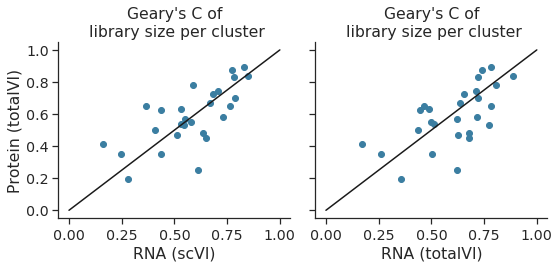

In [88]:
# Plot RNA vs protein library size

fig, ax = plt.subplots(1, 2, figsize = (8,4), sharey = True)

ax[0].scatter(gearyC_results["scvi_RNA"].values, gearyC_results["protein_gearyC"].values, 
           rasterized = True
          )
ax[0].plot([0,1], [0,1], "k")

ax[0].set(ylabel = "Protein (totalVI)")
ax[0].set(xlabel = "RNA (scVI)", title = "Geary's C of\n library size per cluster")

ax[1].scatter(gearyC_results["RNA_gearyC"].values, gearyC_results["protein_gearyC"].values, 
           rasterized = True, 
          )
ax[1].plot([0,1], [0,1], "k")

ax[1].set(xlabel = "RNA (totalVI)", title = "Geary's C of\n library size per cluster")

sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/libsize_figures/libsize_autocorrelation_latentspaces.pdf", dpi = DPI)

## Autocorrelation of features in different latent spaces

* For each protein and RNA feature, calculate the autocorrelation in three different latent spaces:
    * totalVI
    * RNA only (scVI)
    * protein only (PCA)

### Prepare data for autocorrelation calculations

* RNA: log library size normalize raw data
* Protein: PCA latent space (protein only representation)

In [89]:
# log-library size normalize raw RNA data
sc.pp.normalize_per_cell(post_adata_new, counts_per_cell_after=1e4)
sc.pp.log1p(post_adata_new)

In [91]:
# Run PCA and neighbor graph on protein data
adata_protein = anndata.AnnData(post_adata.obsm["protein_expression"].copy(), obs = post_adata.obs)

sc.pp.log1p(adata_protein) 
sc.pp.scale(adata_protein)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [92]:
# Run PCA on proteins
sc.pp.pca(adata_protein, n_comps = 20), # default is 50

# results are in adata_protein.obsm["X_pca"]

(None,)

In [93]:
# Find neighbors
sc.pp.neighbors(adata_protein, use_rep="X_pca", n_neighbors=30, metric="correlation")

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


### Calculate autocorrelations

In [94]:
batch0 = post_adata.obs["batch_indices"] =="0"

In [95]:
post_adata_new[batch0, :].shape

(9264, 4005)

In [96]:
# subsets of adata objects

sub_adata_scvi = post_adata_new[batch0, :].copy()
sub_adata_totalvi = post_adata[batch0, :].copy()
sub_adata_protein = adata_protein[batch0, :].copy()

In [97]:
# scVI latent space (post_adata_new is scVI results, post_adata is raw expression values with totalVI latent space)

scvi_rna_gearyc = []
scvi_protein_gearyc = []

# RNA
for i in range(post_adata.X.shape[1]):
    expr = np.array(sub_adata_scvi.X[:, i]) # log-library size normalized RNA
    autocor = gearys_c(sub_adata_scvi.uns["neighbors"]["connectivities"], expr)
    scvi_rna_gearyc.append(autocor)
    
# Protein
for i in range(post_adata.obsm["protein_expression"].shape[1]):
    expr = np.log1p(np.array(sub_adata_totalvi.obsm["protein_expression"][:, i]))  # log(raw protein)
    autocor = gearys_c(sub_adata_scvi.uns["neighbors"]["connectivities"], expr)
    scvi_protein_gearyc.append(autocor)

In [98]:
# joint latent space from totalVI (post_adata)

totalvi_rna_gearyc = []
totalvi_protein_gearyc = []

# RNA
for i in range(post_adata.X.shape[1]):
    expr = np.array(sub_adata_scvi.X[:, i]) # log-library size normalized RNA
    autocor = gearys_c(sub_adata_totalvi.uns["neighbors"]["connectivities"], expr)
    totalvi_rna_gearyc.append(autocor)

# Protein
for i in range(post_adata.obsm["protein_expression"].shape[1]):
    expr = np.log1p(np.array(sub_adata_totalvi.obsm["protein_expression"][:, i]))  # log(raw protein)
    autocor = gearys_c(sub_adata_totalvi.uns["neighbors"]["connectivities"], expr)
    totalvi_protein_gearyc.append(autocor)

In [99]:
# protein only latent space (PCA)

proteinpca_rna_gearyc = []
proteinpca_protein_gearyc = []

# RNA
for i in range(post_adata.X.shape[1]):
    expr = np.array(sub_adata_scvi.X[:, i]) # log-library size normalized RNA
    autocor = gearys_c(sub_adata_protein.uns["neighbors"]["connectivities"], expr)
    proteinpca_rna_gearyc.append(autocor)

# Protein
for i in range(post_adata.obsm["protein_expression"].shape[1]):
    expr = np.log1p(np.array(sub_adata_totalvi.obsm["protein_expression"][:, i]))  # log(raw protein)
    autocor = gearys_c(sub_adata_protein.uns["neighbors"]["connectivities"], expr)
    proteinpca_protein_gearyc.append(autocor)

In [100]:
gearyc_latentprotein = pd.DataFrame({"Joint\n (totalVI)": totalvi_protein_gearyc, 
                              "RNA only\n (scVI)": scvi_protein_gearyc,
                              "Protein only\n (PCA)": proteinpca_protein_gearyc})

gearyc_latentrna =   pd.DataFrame({"Joint\n (totalVI)": totalvi_rna_gearyc,
                             "RNA only\n (scVI)": scvi_rna_gearyc,
                             "Protein only\n (PCA)": proteinpca_rna_gearyc})

Text(1.0, 1.504612966966004, '$p=0.001$')

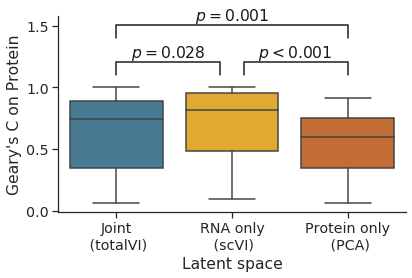

In [101]:
# Plot for protein

fig, ax = plt.subplots(figsize = (6, 4))

ax = sns.boxplot(data = gearyc_latentprotein, orient = "v")
ax.set(xlabel = "Latent space")
ax.set(ylabel = "Geary's C on Protein")

sns.despine()
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 0.9
y, h, col = gearyc_latentprotein.iloc[:, 0].max() + .1, .1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, r"$p=0.028$", ha='center', va='bottom', color=col)

x1, x2 = 1.1, 2
y, h, col = gearyc_latentprotein.iloc[:, 0].max() + .1, .1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, r"$p<0.001$", ha='center', va='bottom', color=col)

x1, x2 = 0, 2
y, h, col = gearyc_latentprotein.iloc[:, 0].max() + .4, .1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, r"$p=0.001$", ha='center', va='bottom', color=col)

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/jointmodel_figures/jointmodel_autocorrelation_protein.pdf", dpi = DPI)

In [102]:
# Calculate spearman correlations between latent space autocorrelations
# Protein 

print("totalVI vs scVI")
print(ranksums(gearyc_latentprotein.iloc[:, 0],
        gearyc_latentprotein.iloc[:, 1]))


print("scVI vs protein")

print(ranksums(gearyc_latentprotein.iloc[:, 1],
        gearyc_latentprotein.iloc[:, 2]))

print("totalVI vs protein")

print(ranksums(gearyc_latentprotein.iloc[:, 0],
        gearyc_latentprotein.iloc[:, 2]))

totalVI vs scVI
RanksumsResult(statistic=-2.196749607173728, pvalue=0.028038333851994748)
scVI vs protein
RanksumsResult(statistic=4.5862708770791905, pvalue=4.512330908794244e-06)
totalVI vs protein
RanksumsResult(statistic=3.2432243477174323, pvalue=0.001181851099270911)


Text(1.0, 2.289925493936368, '$p<0.001$')

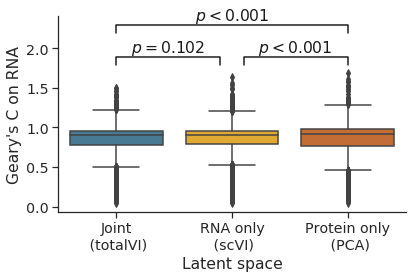

In [103]:
# Plot for RNA

fig, ax = plt.subplots(figsize = (6, 4))

ax = sns.boxplot(data = gearyc_latentrna, orient = "v")
ax.set(xlabel = "Latent space")
ax.set(ylabel = "Geary's C on RNA")

sns.despine()
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 0.9
y, h, col = gearyc_latentrna.iloc[:, 2].max() + .1, .1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, r"$p=0.102$", ha='center', va='bottom', color=col)

x1, x2 = 1.1, 2
y, h, col = gearyc_latentrna.iloc[:, 2].max() + .1, .1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, r"$p<0.001$", ha='center', va='bottom', color=col)

x1, x2 = 0, 2
y, h, col = gearyc_latentrna.iloc[:, 2].max() + .5, .1, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, r"$p<0.001$", ha='center', va='bottom', color=col)

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/spleen_lymph_all/comparative_analysis/jointmodel_figures/jointmodel_autocorrelation_RNA.pdf", dpi = DPI)

In [104]:
# RNA

print("totalVI vs scVI")
print(ranksums(gearyc_latentrna.iloc[:, 0],
        gearyc_latentrna.iloc[:, 1]))


print("scVI vs protein")

print(ranksums(gearyc_latentrna.iloc[:, 1],
        gearyc_latentrna.iloc[:, 2]))

print("totalVI vs protein")

print(ranksums(gearyc_latentrna.iloc[:, 0],
        gearyc_latentrna.iloc[:, 2]))

totalVI vs scVI
RanksumsResult(statistic=-1.6338128171957405, pvalue=0.10229816021654985)
scVI vs protein
RanksumsResult(statistic=-5.57610201899829, pvalue=2.4596771239978534e-08)
totalVI vs protein
RanksumsResult(statistic=-7.127690999093777, pvalue=1.0206658862718712e-12)
